# Discretisation of integral equations
<i>Author: Mikko Pakkanen</i> (email: mikko.pakkanen@uwaterloo.ca)<br>

This notebook implements methods from:

<i>M. S. Pakkanen, X. Miscouridou, M. J. Penn, C. Whittaker, T. Berah, S. Mishra, T. A. Mellan and S. Bhatt (2022): Unifying incidence and prevalence under a time-varying general branching process. Preprint, https://arxiv.org/abs/2107.05579.</i>

We refer the user of this notebook to the paper for context and any unexplained notation.

The objective of the notebook is to exemplify the discretisation of the integral equation that governs <b>prevalence</b>, i.e., the function $t \mapsto \mathrm{Pr}(t,0)$, under a time-varying <i>Bellman-Harris process</i>, as defined in <b>Example 1</b> of the paper (which is a special case of the more general time-varying <i>Crump-Mode-Jagers process</i> studied in the paper). We employ the algorithms introduced in <b>Section 3.1</b> therein. While we work with the Bellman-Harris process here, adapting this notebook for the <i>inhomogeneous Poisson process model</i> of <b>Example 2</b> is simply a matter of redefining notation.

Running this notebook requires <code>numpy</code>, <code>scipy</code> and <code>matplotlib</code>, which we import first.

In [32]:
import numpy as np
from scipy.stats import gamma
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In our example, $L^\tau$ follows the Gamma distribution with shape parameter $3$ and $\tau$-dependent scale parameter
$$
\frac{1}{1+0.01\tau}.
$$
The functions <code>G(t, tau)</code> and <code>g(t, tau)</code> will represent the cumulative distribution function $G^\tau(t)$ and probability density function $g^\tau(t)$ of $L^\tau$, respectively.
The time-varying effective reproduction number of the Bellman-Harris process will be specified as:
$$
R(t) := 1.15 + \sin(0.15t)
$$

In [23]:
def G(t, tau):
    return gamma.cdf(t, a = 3, scale = 1 / (1 + 0.01 * tau))

def g(t, tau):
    return gamma.pdf(t, a = 3, scale = 1 / (1 + 0.01 * tau))

def R(t):
    return 1.15 + np.sin(0.15 * t)

We will generate discretisation over $N = 500$ time steps with step size $\Delta = \frac{100}{N}$.

In [33]:
N = 500
Delta = 100 / N

Since we discretise the equation for prevalence ($f = \mathrm{Pr}$), we specify $h(t,\tau) := 1 - G^{\tau}(t-\tau) = \overline{G}^\tau(t-\tau)$, in accordance with <b>Equation (49)</b> in the paper.

In [34]:
def h(t, tau):
    return 1 - G(t - tau, tau)

And since we are working with the Bellman-Harris specification of the model, we set $\lambda^\tau(u) := R(u+\tau) g^\tau(u)$, via the function <code>lam(u, tau)</code>.

In [35]:
def lam(u, tau):
    return R(u + tau) * g(u, tau)

We are now ready to discretise the integral equation for prevalence using <b>Algorithm 1</b>. This involves a double for-loop, so on most systems it will take a while time to complete. The array <code>f_hat</code> will be used to store the values of the function $(n,i) \mapsto \widehat{f}_{n\Delta}(i\Delta)$. We will finally extract the "diagonal" $\widehat{f}_{n\Delta}(n\Delta)$, $n=0,\ldots,N$, and store it in the vector <code>f_loop</code>. 

In [36]:
fhat = np.zeros(shape = (N + 1, N + 1))

for n in range(N + 1):
    for i in range(n + 1):
        if i == 0:
            fhat[n, i] = h(n * Delta, n * Delta)
        else:
            fhat[n, i] = h(n * Delta, (n - i) * Delta) + np.sum(fhat[n, i - np.arange(1, i + 1)] * lam(Delta * np.arange(1, i + 1), (n - i) * Delta) * Delta)

f_loop = np.diagonal(fhat)

Next, we discretise the equation using <b>Algorithm 2</b>. This requires more preparation. To populate the matrix $H$ used in the algorithm, we specify two auxiliary arrays <code>A_H</code> and <code>B_H</code> which will be used to compute all values of $H$ <i>at once</i> by vectorised evaluation of the function $h(\cdot,\cdot)$. (Unlike in the paper, the upper diagonal of $H$ will not be padded with zeros, but this is immaterial since the algorithm does not actually "see" this part of the matrix.)

In [37]:
A_H = Delta * np.transpose(np.tile(np.arange(0, N + 1), (N + 1, 1)))
B_H = Delta * toeplitz(np.arange(0, N + 1))
H = h(A_H, B_H)

Similarly, we populate the matrix $L$ by evaluating the function <code>lam(t,tau)</code> in a vectorised fashion. (The lower diagonal of $L$ will not consist of zeros but, as above, it will not cause any problem.)

In [38]:
A_L = A_H[0 : N, 0 : N]
B_L = Delta * np.tile(np.flip(np.arange(1, N + 1)), (N, 1))
L = lam(B_L, A_L) * Delta

We are now ready to run the only for-loop in <b>Algorithm 2</b>. Before doing so, we just introduce an array <code>F</code> that corresponds to the matrix $F$ in the algorithm, the only difference being that <code>F</code> has to follow the zero-indexation convention of <code>numpy</code>, so that all indices are shifted by one relative to the paper. This single loop should run much faster than the double loop of <b>Algorithm 1</b>. Once finished, we store the diagonal of <code>F</code> in the vector <code>f_vec</code>. 

In [39]:
F = np.zeros(shape = (N + 1, N + 1))
F[:, 0] = H[:, 0]

for i in range(N):
    B = F[(i + 1) : (N + 1), 0 : (i + 1)] * L[0 : (N - i), (N - i - 1) : (N + 1)]
    F[(i + 1) : (N + 1), i + 1] = H[(i + 1) : (N + 1), i + 1] + np.sum(B, axis = -1)

f_vec = np.diagonal(F)

Finally, we visualise the results and confirm that the outputs of <b>Algorithms 1</b> and <b>2</b>, i.e., vectors <code>f_vec</code> and <code>f_loop</code>, agree.

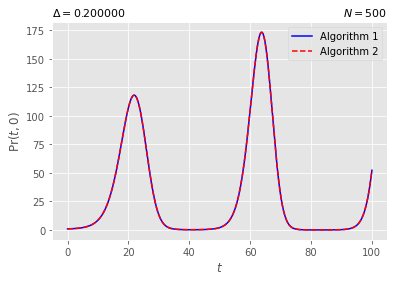

In [44]:
grid = Delta * np.arange(0, N + 1)
plt.plot(grid, f_loop, "b", label = "Algorithm 1")
plt.plot(grid, f_vec, "r--", label = "Algorithm 2")
plt.xlabel("$t$")
plt.ylabel("$\mathrm{Pr}(t,0)$")
plt.title(r"$\Delta=$%f" % Delta, loc = "left", fontsize = 11)
plt.title(r"$N=$%i" % N, loc = "right", fontsize = 11)
plt.legend()
plt.show()